#### Imports

In [189]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import sklearn.ensemble
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

Printing our dataframe to get a look at our columns and get an idea for what could be worth feature engineering

In [190]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


#### Data Cleaning

Intuitively, we would expect lot area to have a strong correlation with Sale Price

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


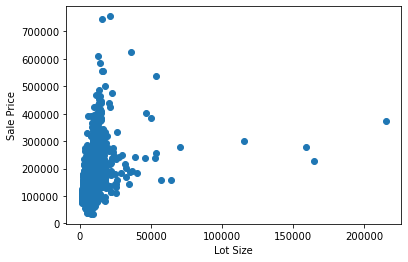

In [191]:
print(train.SalePrice.describe())
plt.scatter(train.LotArea, train.SalePrice)
plt.xlabel('Lot Size')
plt.ylabel('Sale Price')
plt.show()
# Df to store changes we make to the training data
train_cleaned = train

##### Finding numeric features and correlation

In [192]:
numeric_features = train_cleaned.select_dtypes(include=[np.number])
corr = numeric_features.corr()
# Filtering out the most correlated numeric categories (either positively or negatively)
top_numeric = corr['SalePrice'].loc[corr['SalePrice'].abs() > .5]
print(top_numeric.sort_values(ascending = False))

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
Name: SalePrice, dtype: float64


##### Working with OverallQual

             SalePrice
OverallQual           
1                50150
2                60000
3                86250
4               108000
5               133000
6               160000
7               200141
8               269750
9               345000
10              432390


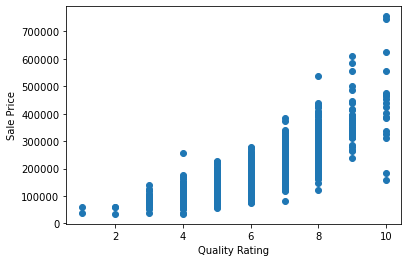

In [193]:
quality_pivot = train_cleaned.pivot_table(index='OverallQual', values='SalePrice', aggfunc=np.median)
print(quality_pivot)

plt.scatter(train_cleaned['OverallQual'], train_cleaned['SalePrice'])
plt.ylabel('Sale Price')
plt.xlabel('Quality Rating')
plt.show()

# Because this is our strongest predictor, we want to remove the outliers at quality rating 4 & 8
qual_4_outlier = train_cleaned[(train_cleaned['SalePrice'] > 200000) & (train_cleaned['OverallQual'] == 4)].index
qual_8_outlier = train_cleaned[(train_cleaned['SalePrice'] > 500000) & (train_cleaned['OverallQual'] == 8)].index
train_cleaned = train_cleaned.drop(qual_4_outlier)
train_cleaned = train_cleaned.drop(qual_8_outlier)

##### Working with GrLivArea

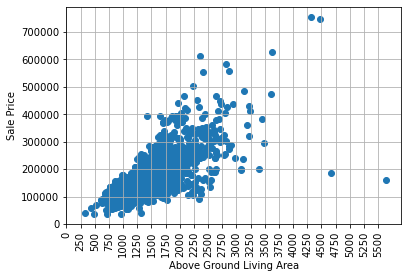

In [194]:
# Making a function to determine grid points so we can filter the outliers here
def xticks_GrLivArea(train_cleaned):
    area_ticks = []
    for area in range(train_cleaned.loc[train_cleaned['GrLivArea'].idxmax()]['GrLivArea']):
        if area % 250 == 0:
            area_ticks.append(area)
    return area_ticks

plt.scatter(train_cleaned['GrLivArea'], train_cleaned['SalePrice'])
plt.ylabel('Sale Price')
plt.xlabel('Above Ground Living Area')
plt.xticks(xticks_GrLivArea(train_cleaned), rotation = 90)
plt.grid()
plt.show()
# Removing outliers
gr_outliers = train_cleaned[train_cleaned['GrLivArea'] > 4550].index
train_cleaned = train_cleaned.drop(gr_outliers)

##### Working with TotalBsmtSF

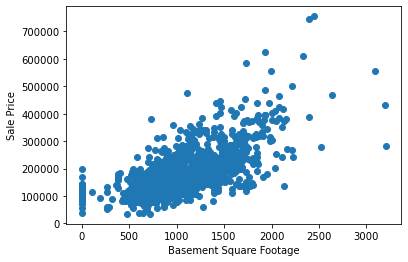

In [195]:
plt.scatter(train_cleaned['TotalBsmtSF'], train_cleaned['SalePrice'])
plt.xlabel('Basement Square Footage')
plt.ylabel('Sale Price')
plt.show()

# Removing outliers
bsmt_outliers = train_cleaned[train_cleaned['TotalBsmtSF'] > 5000].index
train_cleaned = train_cleaned.drop(bsmt_outliers)

##### Working with 1stFlrSF

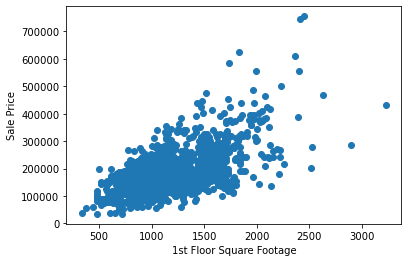

In [196]:
plt.scatter(train_cleaned['1stFlrSF'], train_cleaned['SalePrice'])
plt.xlabel('1st Floor Square Footage')
plt.ylabel('Sale Price')
plt.show()

#### Work with categorical features

In [197]:
# Finding the categoricals
categorical_features = train_cleaned.select_dtypes(exclude=[np.number])
categorical_features.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


##### SaleCondition

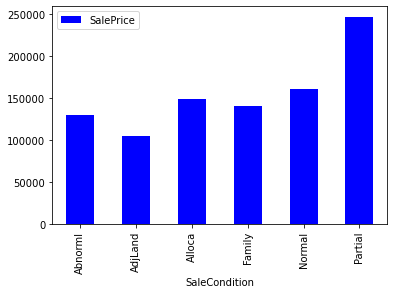

In [198]:
condition_pivot = train_cleaned.pivot_table(index='SaleCondition', values='SalePrice', aggfunc=np.median)
condition_pivot.plot(kind='bar', color='blue')
plt.show()

# Encoding houses sold as "Partial" because they have a much greater influence on the Sale Price
def encode_condition(x):
    if x == 'Partial':
        return 1
    else:
        return 0

train_cleaned['Encoded_Condition'] = train_cleaned['SaleCondition'].apply(lambda x: encode_condition(x))
test['Encoded_Condition'] = test['SaleCondition'].apply(lambda x: encode_condition(x))

##### PoolQC

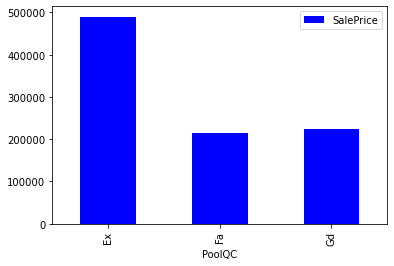

In [199]:
pool_pivot = train_cleaned.pivot_table(index='PoolQC', values='SalePrice', aggfunc=np.median)
pool_pivot.plot(kind='bar', color='blue')
plt.show()

# Encoding houses sold with "Excellent" pool quality
def encode_pool(x):
    if x == 'Ex':
        return 1
    else:
        return 0
    
train_cleaned['Encoded_Pool'] = train_cleaned['PoolQC'].apply(lambda x: encode_pool(x))
test['Encoded_Pool'] = test['PoolQC'].apply(lambda x: encode_pool(x))

Preparing our data for linear regression with our most useful features and splitting into training/testing data

In [200]:
data = train_cleaned.select_dtypes(include=[np.number]).interpolate().dropna()
data.head()

corr = data.corr()
# Filtering out the most correlated numeric categories (either positively or negatively)
top_numeric = corr['SalePrice'].loc[corr['SalePrice'].abs() > 0]
print(top_numeric.sort_values(ascending = False))
row_list = []
for row in top_numeric.index:
    row_list.append(row)
row_list.remove('SalePrice')
row_list.remove('Id')

y = np.log(train_cleaned['SalePrice'])
X = data[row_list]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state = 0)

SalePrice            1.000000
OverallQual          0.799451
GrLivArea            0.732405
TotalBsmtSF          0.651541
GarageCars           0.641021
1stFlrSF             0.631667
GarageArea           0.628911
FullBath             0.560348
TotRmsAbvGrd         0.533489
YearBuilt            0.524800
YearRemodAdd         0.508575
MasVnrArea           0.476016
Fireplaces           0.470816
GarageYrBlt          0.469199
BsmtFinSF1           0.405391
Encoded_Condition    0.358925
LotFrontage          0.332497
OpenPorchSF          0.323286
WoodDeckSF           0.317596
2ndFlrSF             0.315476
HalfBath             0.283553
LotArea              0.257098
BsmtFullBath         0.226132
BsmtUnfSF            0.218926
BedroomAbvGr         0.166029
Encoded_Pool         0.145338
ScreenPorch          0.101980
PoolArea             0.100458
MoSold               0.047665
3SsnPorch            0.045332
BsmtFinSF2          -0.010419
BsmtHalfBath        -0.016097
MiscVal             -0.021028
Id        

Working with Statsmodels to filter insignificant p-values:

First plotting each individual predictor against Sale Price:

In [201]:
for col in X_train.columns:
    x = data[col]
    sm.add_constant(x)
    reg = sm.OLS(y, x).fit()
# Printing a sample summary statistic to show what was evaluated
print(reg.summary2())

                        Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.001     
Dependent Variable:     SalePrice        AIC:                         11374.8324
Date:                   2022-09-22 23:22 BIC:                         11380.1159
No. Observations:       1456             Log-Likelihood:              -5686.4   
Df Model:               1                F-statistic:                 2.318     
Df Residuals:           1455             Prob (F-statistic):          0.128     
R-squared (uncentered): 0.002            Scale:                       144.58    
------------------------------------------------------------------------------------
                   Coef.      Std.Err.       t        P>|t|       [0.025      0.975]
------------------------------------------------------------------------------------
Encoded_Pool      12.9442       8.5023     1.5224     0.1281     -3.7338     29.6223
-------------------------------------

We see that all p-values are significant here, we now need to test all features together

Here we have p-values that are outside of our confidence interval with alpha = .05. We will remove all insigificant factors, and see if the model improves performance

In [202]:
y = np.log(train_cleaned['SalePrice'])
X = data[row_list]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state = 0)

sm.add_constant(X_train)
reg = sm.OLS(y_train, X_train).fit()
y_hat = reg.predict(X_test)
mse = mean_squared_error(y_hat, y_test)
print('Mean Squared Error (all predictors):')
print(mse)

sm.add_constant(X_train)
reg = sm.OLS(y_train, X_train).fit()

# Reading in the Statsmodels summary as a dataframe and finding predictors with low p-vals
results_as_html = reg.summary().tables[1].as_html()
results_table = pd.read_html(results_as_html, header=0, index_col=0)[0]
significant_vals = results_table[results_table['P>|t|'] < .05]
val_list = significant_vals.index.values

# Re-initializing the training and testing data with our list of significant predictors
X_train, X_test, y_train, y_test = train_test_split(X[val_list], y, test_size=0.33, random_state=42)

sm.add_constant(X_train)
reg = sm.OLS(y_train, X_train).fit()
y_hat = reg.predict(X_test)
mse = mean_squared_error(y_hat, y_test)
print('Mean Squared Error (predictors with significant p-values):')
print(mse)

# Finally, creating a model that includes all interaction terms and quadratic terms, then filtering by significance using 
# their p-values. Also filtering via the heirarchical principle so that we don't lose valuable predictors
polynomials = PolynomialFeatures(degree = 2, include_bias = False, interaction_only = False)
xp = pd.DataFrame(polynomials.fit_transform(X_train), columns = polynomials.get_feature_names_out())
xp = sm.add_constant(xp)
reg = sm.OLS(list(y_train), xp).fit()
results_as_html = reg.summary().tables[1].as_html()
results_table = pd.read_html(results_as_html, header=0, index_col=0)[0]
# Creating a dictionary to store keys (predictors) we will use in our final model
significant_dict = dict()
significant_vals = results_table[results_table['P>|t|'] < .05]
list_of_vals = significant_vals.index.values
for val in list_of_vals:
    significant_dict[val] = 1
significant_list = list(significant_dict.keys())

# Final model, hopefully with the lowest MSE when applied to the 
X_train, X_test, y_train, y_test = train_test_split(X[val_list], y, test_size=0.33, random_state=42)

polynomials = PolynomialFeatures(degree = 2, include_bias = False, interaction_only = False)
xp = pd.DataFrame(polynomials.fit_transform(X_train), columns = polynomials.get_feature_names_out())
xp = sm.add_constant(xp[significant_list])
reg = sm.OLS(list(y_train), xp).fit()
X_test = pd.DataFrame(polynomials.fit_transform(X_test), columns = polynomials.get_feature_names_out())
X_test = sm.add_constant(X_test[significant_list])
y_hat = reg.predict(X_test)
mse = mean_squared_error(y_hat, y_test)
print('Mean Squared Error: (interactions/polynomials)')
print(mse)

Mean Squared Error (all predictors):
0.016368286884101975
Mean Squared Error (predictors with significant p-values):
0.017876673331948097
Mean Squared Error: (interactions/polynomials)
0.026136741545845263


We see that dropping the insiginificant columns actually increased our MSE, but likely made our model more generalizable. The predictors with low p-values likely DID contribute to our model, but not in a way that was worth it for the generalizability we were losing.

Using our model on the entire training set to evaluate performance and fit it to run on the test set...

In [203]:
# Using our entire train df to evaluate our model
data = train_cleaned.select_dtypes(include=[np.number]).interpolate().dropna()
y = np.log(data['SalePrice'])
X = data[val_list]

polynomials = PolynomialFeatures(degree = 2, include_bias = False, interaction_only = False)
xp = pd.DataFrame(polynomials.fit_transform(X), columns = polynomials.get_feature_names_out())
xp = sm.add_constant(xp[significant_list])
reg = sm.OLS(list(y), xp).fit()
y_hat = reg.predict(xp)

# Exponentiating to account for our log taken earlier
mse = mean_squared_error(np.exp(y_hat), np.exp(y))
print('Mean Squared Error:')
print(mse)

# Getting the y_hat for our test set
data = test.select_dtypes(include=[np.number]).interpolate().dropna()
X = data[val_list]

polynomials = PolynomialFeatures(degree = 2, include_bias = False, interaction_only = False)
xp = pd.DataFrame(polynomials.fit_transform(X), columns = polynomials.get_feature_names_out())
xp = sm.add_constant(xp[significant_list])
# Our final predicted y_hats!
y_hat = reg.predict(xp)

Mean Squared Error:
724567689.6987488


Although this is on our entire training data, this is comparable to the MSE that we see from other LINEAR models on the leaderboard!